### This notebook makes a couple of plots of p(z) for individual objects

The usual suspects

In [1]:
import tables_io
import numpy as np
import matplotlib.pyplot as plt
import qp

Change this to be the root of the current PZ working area

In [2]:
import os

# pz_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1'
# if that fails you can use this
# pz_dir = '/global/u2/e/echarles/dx'
# pz_dir = '/Users/echarles/pz'

# use user home directory
#pz_dir = os.path.expanduser('~')

# use user home directory plus additional folder
#pz_dir = os.path.expanduser('~') + '/pz'
pz_dir = os.path.expanduser('~') + '/dev'

print("pz_dir:",pz_dir)

pz_dir: /home/phoenix/dev


Get the data, note the switch between different algorithms

In [3]:
algo = 'tpz'
data = qp.read(f'{pz_dir}/data/sandbox_data/5063/{algo}_5063_gold_baseline_v0.hdf5')
#data = qp.read(f'{pz_dir}/projects/dp1/data/gold_baseline/output_estimate_{algo}.hdf5')
#cat = tables_io.read(f'{pz_dir}/data/dp1_v29.0.0/5063/object.parquet')
#cat = tables_io.read(f'{pz_dir}/data/test/dp1_matched_test.hdf5')

In [4]:
#cat['objectId'][23]

Simple function to print some values for a particular object

In [5]:
def print_obj(cat, idx, col_names=None):
    if col_names is None:
        col_names = list(cat.column_names)
    for col_name_ in col_names:
        print(col_name_, cat[col_name_][idx])

In [6]:
col_names = [f"{band}_psfFlux" for band in 'ugrizy']
col_names += [f"{band}_extendedness" for band in 'griz']
col_names += ['objectId']
#print_obj(cat, 23, col_names)

Function to make a "nice_plot"

In [7]:
def nice_plot(subdata, grid=None):
    fig = plt.figure()
    if grid is None:
        grid = np.linspace(0., 3., 301)
    cdfs = subdata.cdf(grid)
    pdfs = subdata.pdf(grid)    
    _ = plt.plot(grid, cdfs, label='cdf')
    _ = plt.plot(grid, pdfs/pdfs.max(), label='pdf')
    _ = plt.axvline(x=subdata.ancil['z_q2p5'], linestyle='dotted', color='gray')
    _ = plt.axvline(x=subdata.ancil['z_q84'], linestyle='dashdot', color='gray')
    _ = plt.axvline(x=subdata.ancil['z_median'], linestyle='dashed', color='gray')
    _ = plt.axvline(x=subdata.ancil['z_q16'], linestyle='dashdot', color='gray')
    _ = plt.axvline(x=subdata.ancil['z_97p5'], linestyle='dotted', color='gray')
    
    _ = plt.legend()
    zmode = subdata.ancil['z_mode'][0]
    zmean = subdata.ancil['z_mean'][0]
    zmedian = subdata.ancil['z_median'][0]
    zstd = subdata.ancil['z_std'][0]
    zq16 = subdata.ancil['z_q16'][0]
    zq84 = subdata.ancil['z_q84'][0]
    zq025 = subdata.ancil['z_q2p5'][0]
    zq975 = subdata.ancil['z_97p5'][0]    
    _ = plt.annotate(f"mode: {zmode:0.3f}", xy=(0.4, 0.8)) 
    _ = plt.annotate(f"mean: {zmean:0.3f}", xy=(0.4, 0.75))     
    _ = plt.annotate(f"std: {zstd:0.3f}", xy=(0.4, 0.7)) 
    _ = plt.annotate(f"q16 -- q86: {zq16:0.3f} -- {zq84:0.3f}", xy=(0.4, 0.65))
    _ = plt.annotate(f"q2.5 -- q97.5: {zq025:0.3f} -- {zq975:0.3f}", xy=(0.4, 0.60))
    return fig

Compute necessary mean values

In [8]:
def my_mean_std(qp_dstn, grid):
    pdfs = qp_dstn.pdf(grid)
    norms = pdfs.sum(axis=1)
    means = np.sum(pdfs * grid, axis=1) / norms
    diffs = (np.expand_dims(grid, -1) - means).T
    wt_diffs = diffs * diffs * pdfs
    stds = np.sqrt((wt_diffs).sum(axis=1)/norms)            
    return means, stds


In [9]:
# AS Adding data for nice plot and code for searching for narrow PDF below
def add_missing_stats(qp_data, grid):
    means, stds = my_mean_std(qp_data, grid)
    qp_data.ancil['z_std'] = stds
    qp_data.ancil['z_mean'] = means
    
    # Add minimal quantiles for plotting
    cdfs = qp_data.cdf(grid)
    qp_data.ancil['z_median'] = grid[np.argmin(np.abs(cdfs - 0.5), axis=1)]
    qp_data.ancil['z_q16'] = grid[np.argmin(np.abs(cdfs - 0.16), axis=1)]
    qp_data.ancil['z_q84'] = grid[np.argmin(np.abs(cdfs - 0.84), axis=1)]
    qp_data.ancil['z_q2p5'] = grid[np.argmin(np.abs(cdfs - 0.025), axis=1)]
    qp_data.ancil['z_97p5'] = grid[np.argmin(np.abs(cdfs - 0.975), axis=1)]
    qp_data.ancil['z_mode'] = qp_data.ancil['zmode']  # Copy existing
    return qp_data

# Use it
grid = np.linspace(0., 3., 301)
data = add_missing_stats(data, grid)

Find a good p(z) with a narrow pdf

In [10]:
np.argmin(data[slice(000, 20000)].ancil['z_std'], axis=0)

np.int64(71)

In [11]:
# # AS Troubleshooting error on above cell: examining the data
# # See what ancillary data exists
# print("Available ancil keys:", data.ancil.keys())

# # Or check the first few entries
# print("Data structure:", type(data))
# if hasattr(data, 'ancil'):
#     print("Ancil type:", type(data.ancil))

Plot it

In [12]:
# AS Check your data size first
print(f"Dataset has {len(data)} galaxies")

best_idx = np.argmin(data[slice(0, len(data))].ancil['z_std'], axis=0)
print(f"Galaxy with smallest std: {best_idx}")

Dataset has 2437 galaxies
Galaxy with smallest std: 71


IndexError: invalid index to scalar variable.

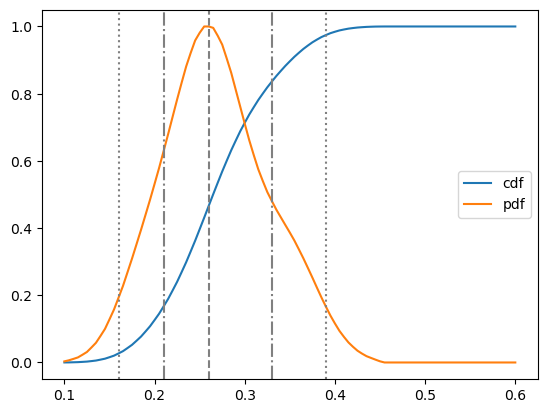

In [13]:
#fig = nice_plot(data[11556], grid=np.linspace(0.1, 0.6, 101))
fig = nice_plot(data[534], grid=np.linspace(0.1, 0.6, 101))

# Plot nice galaxy instead of hardcoded 11556
# fig = nice_plot(data[best_idx], grid=np.linspace(0.1, 0.6, 101))

In [ ]:
data[534].ancil

In [ ]:
fig.savefig('pdf.pdf')

Grab a randomly not great pdf

In [ ]:
fig = nice_plot(data[534])

In [ ]:
fig.savefig('bad_pdf.pdf')

Some checking on the mean and standard deviation, the Mixture Model in qp seems to have issues

In [ ]:
grid = np.linspace(0., 3., 301)

In [ ]:
qp_dstn = data

In [ ]:
means, stds, = my_mean_std(qp_dstn, grid)

In [ ]:
# qp_dstn.mode(grid)

In [ ]:
qp_dstn.mean()

In [ ]:
qp_dstn.std()